## EJECUTA ESTA CELDA PARA AUTENTICARTE CON TU CUENTA DE GMAIL

In [ ]:
!sudo /opt/miniconda/bin/pip install httplib2 apiclient oauth2client==1.5.2 ntplib tzlocal gspread google-api-python-client==1.6.2

In [10]:
from mooclib import *
import inspect, urllib
html, auth_code, userinfo = google_authenticate(PORT_NUMBER=8080)
html

CLICK ON THIS LINK TO AUTHENTICATE WITH YOUR GMAIL ACCOUNT
https://accounts.google.com/o/oauth2/auth?scope=profile+email&redirect_uri=http%3A%2F%2Flocalhost%3A8080&response_type=code&client_id=486275613361-7nk9ktukfcfjevfoe3tamjp0pmbjmprs.apps.googleusercontent.com&access_type=offline
waiting for authentication ...
authentication succeeded


,johanyepes@gmail.comJohan Sebastian Yepes Riosgoogle id: 115131859555741875188authorization code: 4/fQDUZimuFaahlCRo6CrgJBnftogfDOQCnEjd3fsNuOznZc8Eomz7qG5pK8T-cjdwqcUhT0JpAvefHB691ye7stE


In [9]:
from sklearn.datasets import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")

## Ejercicio 1

completa la siguiente función para que, dado un estimador, devuelva una lista con $n$ réplicas del mismo. Usa la función [`sklearn.base.clone`](http://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html)

In [1]:
def clone_estimators(estimator, n):
    from sklearn.base import clone
    estimators = [clone(estimator) for i in range(n)]
    return estimators

import urllib, inspect
src1 = urllib.quote_plus(inspect.getsource(clone_estimators))

#### evaluate your answer before submitting:

In [2]:
!./run CHECK_SOLUTION PS7_1 $src1

evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [3]:
!./run SUBMIT_SOLUTION PS7_1 $src1

connecting ... registering submission for johanyepes@gmail.com ...
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


## Ejercicio 2

Completa la siguiente función para que, cada estimador de la lista `estimators`:
    
- muestree un porcentaje `train_pct` de datos para entrenamiento de `X` e `y`.
- entrene el estimador con los datos muestreados

y finalmente devuelva la lista con los estimadores entrenados. Observa que cada estimador se entrena con una muestra distinta

In [38]:
def sample_train(estimators, X, y, train_pct):
    from sklearn.cross_validation import train_test_split      
    
    for estimator in estimators:
        X_train, _, y_train, _ = train_test_split(X, y, train_size=train_pct)
        estimator.fit(X_train, y_train)

    return estimators

import urllib, inspect
src2 = urllib.quote_plus(inspect.getsource(sample_train))

#### evaluate your answer before submitting:

In [39]:
!./run CHECK_SOLUTION PS7_2 $src2

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [11]:
!./run SUBMIT_SOLUTION PS7_2 $src2

connecting ... registering submission for johanyepes@gmail.com ...
/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


## Ejercio 3

organiza tu código de los dos ejercicios anteriores en la siguiente clase y, además, implementa un método `predict` en el que clasifique un cada ejemplo según la clase mayoritaria predicha por todos los estimadores. Observa que:

- `self.base_estimator` tiene el estimador base
- `self.nb_resamples` y `self.train_pct` contienen el número de remuestreos y el porcentaje de train para cada muestreo
- `self._estimators` ha de contener la lista de estimadores clonados del estimador base

In [35]:
def ResamplingEnsemble(**args): # hack for inspect to work with classes
    
    class ResamplingEnsemble_class:

        def __init__(self, base_estimator, nb_resamples, train_pct):
            self.base_estimator = base_estimator
            self.nb_resamples   = nb_resamples
            self.train_pct      = train_pct

        def fit(self, X, y):
            from sklearn.cross_validation import train_test_split        
            from sklearn.base import clone

            self._estimators     = [clone(self.base_estimator) for i in range(self.nb_resamples)]
            for estimator in self._estimators:
                X_train, _, y_train, _ = train_test_split(X, y, train_size=self.train_pct)
                estimator.fit(X_train, y_train)

        def predict(self, X):
            preds = np.zeros(X.shape[0])
            for estimator in self._estimators:
                preds += estimator.predict(X)
            
            preds = (preds>(len(self._estimators)/2.)).astype(int)
            
            return preds

        def score(self, X,y):
            return np.sum(self.predict(X)==y)*1./len(X)

        def get_params(self, deep=None):
            return {"base_estimator":self.base_estimator, 
                    "nb_resamples": self.nb_resamples, 
                    "train_pct": self.train_pct}
        
    return ResamplingEnsemble_class(**args)

import urllib, inspect
src3 = urllib.quote_plus(inspect.getsource(ResamplingEnsemble))

Comprueba tu código. Observa las fronteras de clasificación creadas a partir de clasificadores sencillos. El ensemble debe de tener un score de 0.8 approx. Ejecútalo varias veces para adquirir seguridad y entendimiento.

Text(0.5,1,'SINGLE TREE score 0.720')

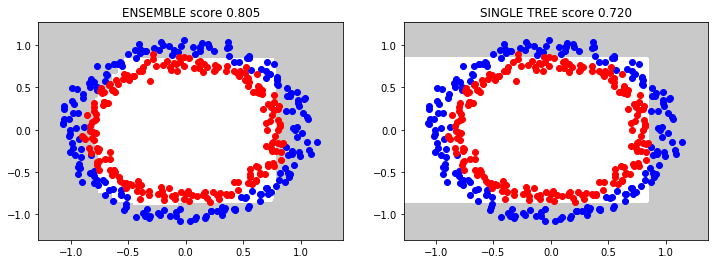

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
X,y = make_circles(400, noise=0.05)

dt = DecisionTreeClassifier(max_depth=3)
rs = ResamplingEnsemble(base_estimator=dt, nb_resamples=10, train_pct=.1)
rs.fit(X,y)
dt.fit(X,y)

plt.figure(figsize=(12,4))
plt.subplot(121)
plot_2Ddata_with_boundary(rs.predict, X,y)
plt.title("ENSEMBLE score %.3f"%np.mean(cross_val_score(rs, X,y, cv=10)))
plt.subplot(122)
plot_2Ddata_with_boundary(dt.predict, X,y)
plt.title("SINGLE TREE score %.3f"%np.mean(cross_val_score(dt, X,y, cv=10)))

#### evaluate your answer before submitting:

In [37]:
!./run CHECK_SOLUTION PS7_3 $src3

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [ ]:
!./run SUBMIT_SOLUTION PS7_3 $src3